<center><img src="images/header.png" width=400></center>

<h1><center>Основы машинного обучения</center></h1>
<hr>
<h2><center>Методы обучения без учителя: Домашняя работа</center></h2>

Правила:

* Отчеты принимаются до 23:59 21 ноября. Вы должны залить ваш ноутбук в [colab](https://colab.research.google.com) и дать на него ссылку в форме сдачи ДЗ на портале
* Работоспособность будет проверяться в коллабе. Это значит что:
    1. Вам надо удостовериться, что код отрабатывает от начала и до конца. Выполните аналог "Restart Kernel and Run All" в colab
    2. Убедитесь, что данные автоматически подгружается с помощью команды `!wget` (см семинары для примера). Все нужные данные есть [здесь](https://github.com/vadim0912/MLbase_2021_spring/tree/master/lecture04/data)
    3. Все необходимые модули тоже устанавливаются на лету через `!pip`


In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-talk')
plt.rcParams['figure.figsize'] = (15,10)

# Задача про датчики на руках

В этом задании мы применим метод главных компонент на многомерных данных и постараемся найти оптимальную размерность признаков для решения задачи классификации

Исходными [данными](http://archive.ics.uci.edu/ml/machine-learning-databases/auslan2-mld/auslan.data.html) являются показания различных сенсоров, установленных на руках человека, который умеет общаться на языке жестов.

В данном случае задача ставится следующим образом: по показаниям датчиков (по 11 сенсоров на каждую руку) определить слово, которое было показано человеком.

Как можно решать такую задачу?

Показания датчиков представляются в виде временных рядов. Посмотрим на показания для одного из "слов"

In [3]:
# Загружаем данные сенсоров
df_database = pd.read_csv('./data/sign_database.csv')

# Загружаем метки классов
sign_classes = pd.read_csv('./data/sign_classes.csv', index_col=0, header=0, names=['id', 'class'])

In [4]:
# Столбец id - идентификаторы "слов"
# Столбец time - метка времени
# Остальные столбцы - показания серсоров для слова id в момент времени time

df_database.head()

,x_l,x_r,y_l,y_r,z_l,z_r,roll_l,roll_r,pitch_l,pitch_r,...,forefinger_l,forefinger_r,middle_l,middle_r,ring_l,ring_r,little_l,little_r,id,time
0,-0.097816,-0.127761,-0.029051,0.537977,0.249162,0.508908,0.239445,0.039819,0.0,0.007009,...,0.369149,0.381857,0.570995,0.343431,0.0,0.000000,0.0,0.133088,0,0
1,-0.102460,-0.126734,-0.029230,0.537758,0.246477,0.507236,0.240116,0.039057,0.0,0.007009,...,0.326618,0.402561,0.595044,0.291571,0.0,0.000000,0.0,0.084865,0,1
2,-0.103085,-0.125618,-0.028605,0.537464,0.244890,0.507273,0.234753,0.039057,0.0,0.007494,...,0.295135,0.436131,0.639491,0.242470,0.0,0.000000,0.0,0.026230,0,2
3,-0.102639,-0.126020,-0.028873,0.537306,0.244890,0.507639,0.232072,0.026864,0.0,0.009431,...,0.239311,0.521583,0.723905,0.224264,0.0,0.014668,0.0,0.015033,0,3
4,-0.105139,-0.127538,-0.028917,0.537513,0.244816,0.506626,0.234083,0.026864,0.0,0.008947,...,0.199478,0.675103,0.786566,0.235298,0.0,0.010813,0.0,0.000815,0,4


In [5]:
# Выберем одно из слов с идентификатором = 0
sign0 = df_database.query('id == 0')\
                   .drop(['id'], axis=1)\
                   .set_index('time')

<AxesSubplot:xlabel='time'>

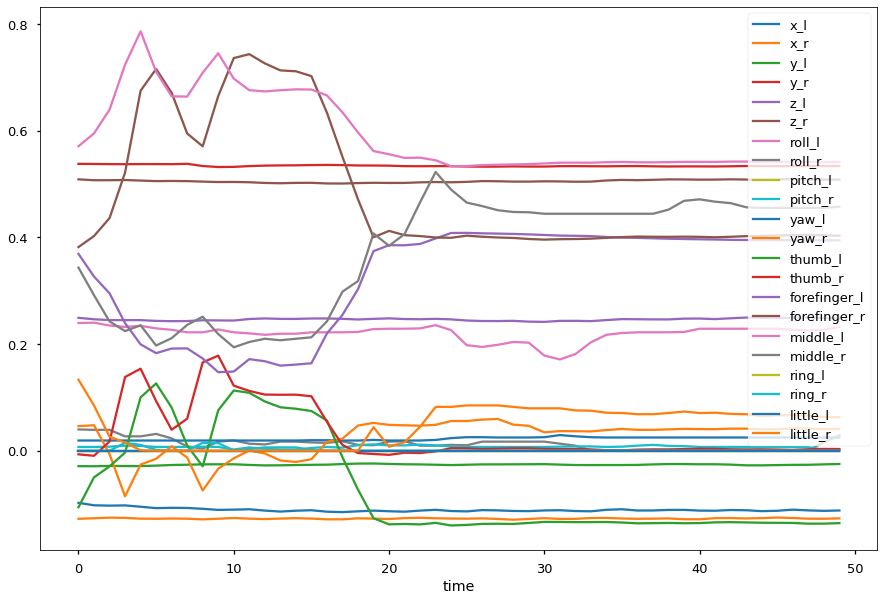

In [6]:
sign0.plot()

Для каждого из "слов" у нас есть набор показаний сенсоров с разных частей руки в каждый момент времени.

Идея нашего подхода будет заключаться в следующем – давайте для каждого сенсора составим набор характеристик (например, разброс значений, максимальное, минимальное, среднее значение, количество "пиков", и т.п.) и будем использовать эти новые "признаки" для решения задачи классификации.

## Расчет новых признаков

Признаки мы будем считать с помощью библиотеки [tsfresh](http://tsfresh.readthedocs.io/en/latest/index.html). Генерация новых признаков может занять много времени, поэтому мы сохранили посчитанные данные, но при желании вы можете повторить вычисления.

In [7]:
from sklearn.preprocessing import LabelEncoder

In [8]:
## Если не хотите долго ждать - не убирайте комментарии
# !pip install tsfresh


# import tsfresh
# from tsfresh.feature_extraction import extract_features
# from tsfresh.feature_selection import select_features
# from tsfresh.utilities.dataframe_functions import impute
# from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters, settings, EfficientFCParameters


# sign_features = extract_features(df_database, column_id='id', column_sort='time',
#                                  default_fc_parameters=EfficientFCParameters(),
#                                  impute_function=impute)

# enc = LabelEncoder()
# enc.fit(sign_classes.loc[:, 'class'])
# sign_classes.loc[:, 'target'] = enc.transform(sign_classes.loc[:, 'class'])

# sign_features_filtered = select_features(sign_features, sign_classes.loc[:, 'target'])

# filepath = './data/tsfresh_features_filt.csv.gz'
# sign_features_filtered.to_csv(filepath, compression='gzip')

In [9]:
# !mkdir ./data
# !wget https://www.dropbox.com/s/x6b9mqxlw5ijcuf/tsfresh_features_filt.csv.gz?dl=0 -O ./data/tsfresh_features_filt.csv.gz
filepath = './data/tsfresh_features_filt.csv'
sign_features_filtered = pd.read_csv(filepath)

In [10]:
sign_features_filtered.shape

(2565, 11517)

In [11]:
sign_features_filtered.head()

,Unnamed: 0,ring_r__maximum,"ring_r__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""max""","ring_r__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""mean""","ring_r__fft_coefficient__attr_""abs""__coeff_2","ring_r__linear_trend__attr_""stderr""",ring_r__quantile__q_0.9,"ring_r__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""max""",ring_r__variance,ring_r__standard_deviation,...,forefinger_l__large_standard_deviation__r_0.15000000000000002,little_r__symmetry_looking__r_0.15000000000000002,z_l__symmetry_looking__r_0.35000000000000003,roll_r__large_standard_deviation__r_0.25,roll_r__large_standard_deviation__r_0.45,little_r__symmetry_looking__r_0.05,pitch_l__symmetry_looking__r_0.05,z_l__large_standard_deviation__r_0.45,little_l__symmetry_looking__r_0.05,y_l__symmetry_looking__r_0.35000000000000003
0,0,0.014764,0.998626,0.000174,0.047854,0.000034,0.006166,0.000423,0.000015,0.003881,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,0.017579,0.017579,0.000180,0.045183,0.000027,0.003599,0.000397,0.000012,0.003399,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2,0.043917,0.043917,0.000737,0.059952,0.000092,0.028252,0.001034,0.000142,0.011921,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4,0.061037,0.061037,0.001453,0.402618,0.000127,0.047034,0.001777,0.000314,0.017728,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Базовая модель

В результате у нас получилось очень много признаков (11516 или больше), давайте применим метод главных компонент, чтобы получить сжатое признаковое представление, сохранив при этом предиктивную силу в модели.

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Создадим бейзлайн без уменьшения размерности. Гиперпараметры модели подбирались произвольно

In [13]:
# Подготовим данные на вход в модель

# признаки
X = sign_features_filtered.values

# классы
y = sign_classes['class'].values

In [14]:
# Будем делать кросс-валидацию на 5 фолдов
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

base_model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier(n_neighbors=9))
])

base_cv_scores = cross_val_score(base_model, X, y, cv=cv, scoring='accuracy')

In [15]:
base_cv_scores

array([0.92397661, 0.90838207, 0.9122807 , 0.93177388, 0.92202729])

## Метод главных компонент (5 баллов)

* (1) Добавьте в пайплайн `base_model` шаг с методом главных компонент. Начиная с версии 0.18 в sklearn добавили разные солверы для PCA. Дополнитенльно задайте в модели следующие параметры: `svd_solder = "randomized"` и `random_state=123`. Остальные гиперпараметры модели и способ кросс-валидации оставьте без изменений
* (1 + 2) Найдите такое наименьшее количество главных компонент, что качество нового пайплайна превыcит 90%. За +2 бала найдите решение не полным перебором (руками перебрать пару значений, тоже считается полным перебором). Можете считать, что функция зависимости качества от количества компонент монотонно неубывающая. 
* (1) Укажите долю объяснённой дисперсии при найденной настройке PCA  (для этого надо обучить PCA на всех данных). Долю объясненной дисперсии можно найти в атрибуте `explained_variance_ratio`

In [16]:
def optimize_components_pca(_n_component):
    PCA_model = Pipeline([
        ('scaler', StandardScaler()),
        ('PCA', PCA(
            n_components=_n_component,
            svd_solver="randomized",
            random_state=123,

        )),
        ('clf', KNeighborsClassifier(n_neighbors=9))
    ])
    return cross_val_score(PCA_model, X, y, cv=cv,
                           scoring='accuracy').mean()

In [17]:
def binary_search(fnc, left, right, value):
    while left < right + 1:
        center = int((right + left) / 2)
        if fnc(center) > value:
            right = center - 1
        else:
            left = center + 1
    return center

In [18]:
components = binary_search(optimize_components_pca, left=1, right=200, value=0.9)

In [19]:
components

80

In [20]:
optimize_components_pca(components)

0.9021442495126706

In [21]:
optimize_components_pca(components - 1)

0.8959064327485379

In [22]:
pca_model = PCA(n_components=components, svd_solver='randomized', random_state=123)
pca_model.fit(X, y)
pca_model.explained_variance_ratio_

array([7.39004509e-01, 1.02168199e-01, 6.03454706e-02, 5.20832011e-02,
       1.65142352e-02, 1.60063099e-02, 6.45623114e-03, 6.42239572e-03,
       9.99448343e-04, 5.40480630e-17, 2.36981962e-18, 2.16949678e-22,
       6.11516226e-24, 8.57875717e-25, 2.21369027e-25, 1.87265045e-25,
       1.32812585e-25, 1.00101713e-25, 1.38225053e-26, 5.72183525e-27,
       4.31701710e-27, 3.96567915e-27, 2.16547353e-27, 1.80220410e-27,
       1.52907366e-27, 1.39763016e-27, 1.13945176e-27, 5.69806242e-28,
       1.84111200e-28, 1.28703385e-28, 1.06563420e-28, 9.81720662e-29,
       9.66075640e-29, 7.22358276e-29, 6.31901398e-29, 4.51616823e-29,
       3.96051759e-29, 2.70486419e-29, 2.52098063e-29, 2.21017138e-29,
       2.05215550e-29, 1.98912843e-29, 1.84369885e-29, 1.56217172e-29,
       1.38976680e-29, 1.21116055e-29, 1.05063342e-29, 9.33664301e-30,
       9.31751316e-30, 8.83299824e-30, 8.46846788e-30, 8.39547205e-30,
       7.65500114e-30, 7.25791242e-30, 7.23913448e-30, 7.09357620e-30,
      

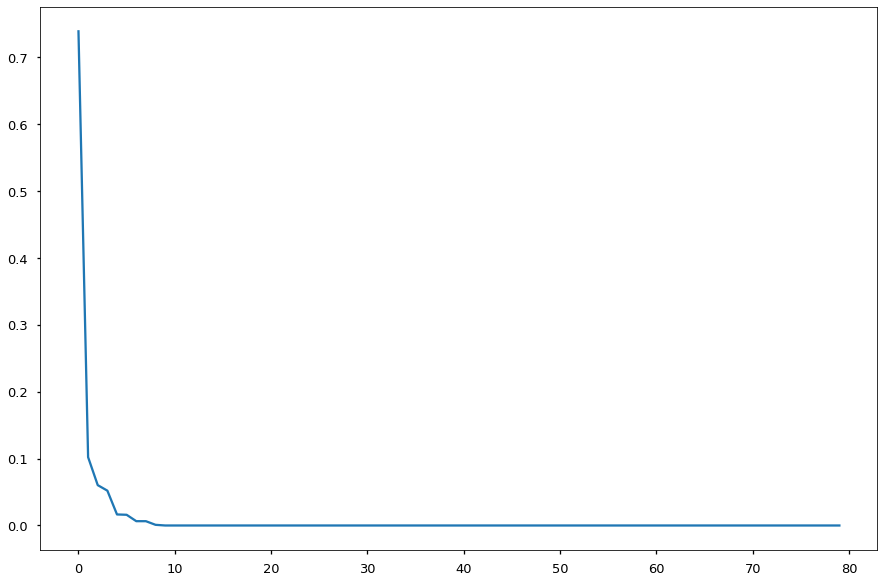

In [23]:
plt.plot(pca_model.explained_variance_ratio_)

# Задача про кластеризацию текстов

Рассмотрим коллекцию новостных сообщений за первую половину 2017 года. Про каждое новостное сообщение известны:
* его заголовок и текст
* дата его публикации
* событие, о котором это новостное сообщение написано 
* его рубрика

In [24]:
df = pd.read_csv('./data/news.csv', encoding='utf8')
df.head()

,text,date,event,class
0,В ПЕТЕРБУРГЕ ПРОШЕЛ МИТИНГ ПРОТИВ ПЕРЕДАЧИ ИС...,2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ
1,"Lenta.co, Москва, 14 января 2017 СИТУАЦИЯ С П...",2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ
2,"Аргументы и Факты (aif.ru), Москва, 14 января...",2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ
3,"Google Новости ТОП, Москва, 14 января 2017 АК...",2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ
4,"Газета.Ru, Москва, 13 января 2017 В МОСКОВСКО...",2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ


In [25]:
df.loc[:, 'class'].value_counts()

Важные мировые события                           403
Внутренняя политика РФ                           364
Внутренняя политика РФ: оппозиция                277
Теракты                                          200
Международные отношения                          153
Спорт                                            102
Внутренняя политика: культура                    100
Проишествия  РФ                                  100
Спорт                                            100
Международные отношения: Криминальная хроника     82
Технологии                                        49
Name: class, dtype: int64

Попробуем кластеризовать документы (каким-либо методом) и сравним полученное разбиение с данными рубликами с помощью ARI

## Стандартная предобработка текстов

Ниже выполняется набор операций по предобработке текстов. Возможно на этом курсе про это не будет идти речь, однако идея довольно простая. Просто следите за комментариями =)

In [26]:
df.text[0] # Так выглядит первая статья до преобработки

' В ПЕТЕРБУРГЕ ПРОШЕЛ МИТИНГ ПРОТИВ ПЕРЕДАЧИ ИСААКИЕВСКОГО СОБОРА РПЦ В Санкт-Петербурге люди устроили акцию протеста против передачи Исаакиевского собора в безвозмездное пользование РПЦ. Жители Петербурга собрались на Исаакиевской площади, чтобы высказаться против передачи Исаакиевского собора в безвозмездное пользование РПЦ, передает ТАСС. Акция проходит в формате встречи с депутатами Законодательного собрания города и не требует согласования с властями. Участники акции не используют какую-либо символику и плакаты, а также мегафоны или средства звукоусиления. По словам депутата Алексея Ковалева, на Исаакиевскую площадь пришло примерно тысяча человек. Перед участниками протеста выступили депутаты местного парламента Борис Вишневский и Максим Резник, которые заявили о том, что потребуют отмены решения Смольного. Вишневский сообщил, что акция будет проходить в виде встречи депутатов с избирателями. "Закон Санкт-Петербурга предоставляет нам право встречаться с избирателями, такую встречу

In [27]:
import re

# Оставляем только кириллические символы
regex = re.compile(u"[А-Яа-я]+")

def words_only(text, regex=regex):
    return " ".join(regex.findall(text))


df.text = df.text.str.lower()
df.loc[:, 'text'] = df.text.apply(words_only)

In [28]:
import nltk

In [29]:
from nltk.corpus import stopwords
nltk.download('stopwords')

# Удаляем стоп-слова
mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', u'также',  'т', 'д', '-', '-']

def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return u" ".join([token for token in text.split() if not token in mystopwords])
    except:
        return u""
    
df.text = df.text.apply(remove_stopwords)   

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/romansim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
!pip install pymystem3
!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz

--2022-04-29 22:34:23--  http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving download.cdn.yandex.net (download.cdn.yandex.net)... 5.45.205.244, 5.45.205.241, 5.45.205.245, ...
Connecting to download.cdn.yandex.net (download.cdn.yandex.net)|5.45.205.244|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ext-cachev2-m9mts201.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz?lid=1524 [following]
--2022-04-29 22:34:28--  https://ext-cachev2-m9mts201.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz?lid=1524
Resolving ext-cachev2-m9mts201.cdn.yandex.net (ext-cachev2-m9mts201.cdn.yandex.net)... 212.188.75.4, 2a02:28:1:38::4
Connecting to ext-cachev2-m9mts201.cdn.yandex.net (ext-cachev2-m9mts201.cdn.yandex.net)|212.188.75.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16457938 (16M) [application/octet-stream]
Saving to: ‘mystem-3.0-linux3.1-64b

In [34]:
%%time 
from pymystem3 import Mystem


# нормализуем текст
bin_path = "./mystem"
m = Mystem(bin_path)
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()
    except:
        return " "

df.text = df.text.apply(lemmatize)

CPU times: user 3.02 ms, sys: 541 µs, total: 3.56 ms
Wall time: 3.53 ms


In [35]:
mystoplemmas = [u'который', u'прошлый', u'сей', u'свой', u'наш', u'мочь']

# Еще кое-что удаляем
def  remove_stoplemmas(text, mystoplemmas = mystoplemmas):
    try:
        return " ".join([token for token in text.split() if not token in mystoplemmas])
    except:
        return ""

df.text = df.text.apply(remove_stoplemmas)  

In [36]:
df.text[0] # так выгладит первая статья после предобработки

''

## Вычисление сходства (1 балл)

С помощью `TfidfVectorizer` и `pairwise_distances` расчитайте **косинусное** расстояние между всеми парами документов к корпусе.

Про векторизацию текстов с помощью `CountVectorizer` или `TfidfVectorizer` можно почитать [тут](https://www.machinelearningmastery.ru/gentle-introduction-bag-words-model/) 

Запишите результат в переменную `S`

In [ ]:
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances

In [ ]:
vect = TfidfVectorizer()
texts = df.text.values

In [ ]:
X = vect.fit_transform(texts)

In [ ]:
S = pairwise_distances(X)

[[], []]

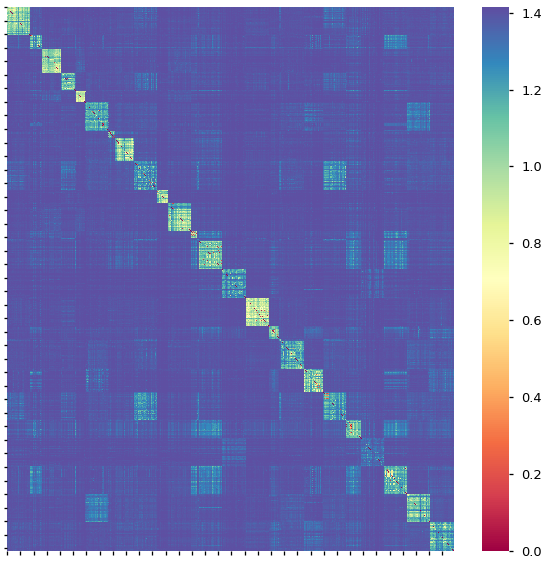

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(data=S, cmap = 'Spectral').set(xticklabels=[],yticklabels=[])

Вы должны пронаблюдать, что между некоторыми текстами есть довольно высокое сходство по содержанию слов - мы видим, что вдоль диагонали матрицы попарых расстояний есть "блоки" по похожести. 

Нам конечно же повезло, так как тексты заранее были удачно упорядочены. В реальности такой живописной картины мы скорее всего не увидим.

Попробуем их кластеризовать

## DBSCAN (4 балла)
* (2) Воспользуйтесь методикой оценки параметров для алгоритма DBSCAN. Не копипастите `min_pts = 2` из семинара! Используйте **косинусную** меру близости.
* (1) Выделите кластеры. Для каждого кластера (кроме -1, если он будет) выведите несколько текстов и умозрительно определите его тематику. Можете подсмотреть в исходные тематики корпуса
* (1) Оцените сходство с изначальными рубриками визуально (с помощью матрицы перемешивания) и с помощью [Adjusted Rand Index](https://en.wikipedia.org/wiki/Rand_index)

In [48]:
from sklearn.cluster import DBSCAN
from sklearn.metrics.cluster import adjusted_rand_score
from tqdm.notebook import tqdm

In [ ]:
def adj_rand_score(eps, min_pts):
  dbscan = DBSCAN(eps=eps, min_samples=min_pts)
  dbscan.fit(S)
  return adjusted_rand_score(df.loc[:, 'class'], dbscan.labels_)

In [ ]:
for eps in tqdm(eps_vals):
  for min_pts in tqdm(min_pts_vals, leave=False):
    val = adj_rand_score(eps, min_pts)
    if val > max_val:
      max_val = val
      EPS = eps
      MIN_PTS = min_pts

In [44]:
eps_vals = np.linspace(0.01, 1, 20)
min_pts_vals = np.arange(30, 50)

max_val = 0
eps = None
min_pts= None
for _eps in eps_vals:
  for _min_pts in min_pts_vals:
    val = adj_rand_score(eps, min_pts)
    if val > max_val:
      max_val = val
      eps = _eps
      min_pts = _min_pts

NameError: name 'adj_rand_score' is not defined

In [45]:
print(max_val, eps, min_pts)

0 None None


In [46]:
dbscan = DBSCAN(eps=eps, min_samples=min_pts)
dbscan.fit(S)

NameError: name 'DBSCAN' is not defined

In [ ]:
labels = dbscan.labels_

In [40]:
pd.crosstab(df.loc[:, 'class'], labels)

NameError: name 'labels' is not defined

In [47]:
adjusted_rand_score(df.loc[:, 'class'], labels)

NameError: name 'adjusted_rand_score' is not defined